In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense,Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the test labels
<li> Reading test labels from the csv </li>
<li> Conducting stratified train-validation split</li>

In [13]:
input_data_folder = "drive/MyDrive/GovTech VA Assessment/Assignment 1 - Training Data/"
# input_data_folder = "./Assignment 1 - Training Data/"

In [29]:
labels_df = pd.read_csv(input_data_folder+'labels.csv')
labels_df.head()

,image,category
0,2788353.jpg,0
1,2782131.jpg,0
2,2884349.jpg,0
3,2900596.jpg,0
4,2841543.jpg,0


In [30]:
# Convert the category to str
labels_df.loc[:,"category"] = labels_df.loc[:,"category"].astype(str)

In [31]:
labels_df.shape[0]

900

In [32]:
# Checking the number of unique categories
n_classes = labels_df.category.nunique()
n_classes

5

In [33]:
# Checking the distribution of categories
labels_df.groupby("category").count()

,image
category,
0,100
1,200
2,200
3,200
4,200


In [34]:
# Stratified train-validation split split
# Especially with such a small dataset and numerious different categories, it is important to ensure that the model is able to see and learn from all the categories
# 80-20 train-validation split is done to ensure that the model has sufficient data to train on while having sufficiently large validation data to check if the model is overfitting
image_train, image_val, category_train, category_val = train_test_split(labels_df.image, labels_df.category, test_size=0.2, stratify=labels_df.category, random_state=42)

In [35]:
# Separating the Training Data
train_df = labels_df.loc[labels_df.image.isin(image_train),:].copy()
train_df.groupby("category").count()

,image
category,
0,80
1,160
2,160
3,160
4,160


In [36]:
train_df.head()

,image,category
0,2788353.jpg,0
3,2900596.jpg,0
4,2841543.jpg,0
5,2856056.jpg,0
6,2892525.jpg,0


In [37]:
# Separating the Validation Data
val_df = labels_df.loc[labels_df.image.isin(image_val),:].copy()
val_df.groupby("category").count()

,image
category,
0,20
1,40
2,40
3,40
4,40


In [38]:
val_df.head()

,image,category
1,2782131.jpg,0
2,2884349.jpg,0
14,2798385.jpg,0
20,2837597.jpg,0
21,2829278.jpg,0


# Data Augmentation Testing
Important to generate samples for manual inspection of the Augmented image to ensure that the model is learning pictures that are realistic and recognisable by humans too


In [39]:
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2, height_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    # rotation_range=30, fill_mode='nearest',
    # zoom_range=0.2
    )

Found 720 validated image filenames belonging to 5 classes.


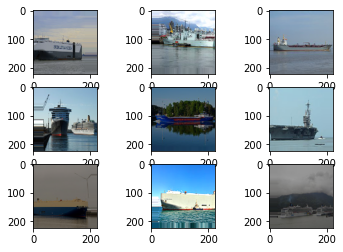

In [40]:
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow_from_dataframe(
		dataframe=train_df,
		directory=input_data_folder,
		x_col="image",
		y_col="category",
		batch_size=9,
		shuffle=True,
		class_mode="categorical",
    target_size=(224,224)):

    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(224, 224,3))
    # show the plot
    plt.show()
    break

# Data Augmentation Implementation

## Train Set Image Augmentation
Important Benefits:

*   **Increase the training data size**: Especially since the model only has 80-160 original images to learn from.
*   **Reduce overfitting of model**: Allows the models to learn to classify the image even when the input image is noisy

In [ ]:
input_image_generators = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2, height_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    # rotation_range=30, fill_mode='nearest',
    # zoom_range=0.2
    )

In [ ]:
train_data_gen = input_image_generators.flow_from_dataframe(
		dataframe=train_df,
		directory=input_data_folder,
		x_col="image",
		y_col="category",
		batch_size=20,
		seed=42,
		shuffle=True,
		class_mode="categorical",
    target_size=(224,224))

Found 720 validated image filenames belonging to 5 classes.


## Validation Set Image Augmentation
Important Benefits:
*   **Increase the validation data size**: For better validation/tuning of model, especially since validation set is very small.



In [ ]:
input_image_generators = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2, height_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    # rotation_range=30, fill_mode='nearest',
    # zoom_range=0.2
    )

In [ ]:
validation_data_gen = input_image_generators.flow_from_dataframe(
		dataframe=val_df,
		directory=input_data_folder,
		x_col="image",
		y_col="category",
		batch_size=20,
		seed=42,
		shuffle=True,
		class_mode="categorical",
    target_size=(224,224))

Found 180 validated image filenames belonging to 5 classes.


# Model Building: Using the Pretrained VGG16 Model to extract Features
Due to the severe lack of training data, the model will have to be built upon the pretrained VGG16 model and not trained from scratch.

In [ ]:
# Loading the pretrained VGG16 model without the fully connected layers
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
print(vgg_model.summary())

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# Fixing the weights of the convolutional layers
# Due to the lack of sizeable training data to train the weights of the layers, the convolutional layers wil not be fine tuned
for layer in  vgg_model.layers:
    layer.trainable = False 

In [ ]:
# Create a new 'top' fully-connected layers
# Trial and tested. Due to the lack of sizeable training data to train the weights of the layers, there will the output layer will be the only Dense layer.
top_model = vgg_model.output
top_model = Flatten(name="flatten")(top_model)
output_layer = Dense(n_classes, activation='softmax')(top_model)

# Group the convolutional base and new fully-connected layers into a Model object.
final_model = Model(inputs=vgg_model.input, outputs=output_layer)

In [ ]:
# Compile the model
final_model.compile(
    optimizer= Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Model Training

In [ ]:
n_steps = train_data_gen.samples // 20
n_val_steps = validation_data_gen.samples // 20
n_epochs = 100

In [ ]:
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=n_epochs)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=30, verbose=1, mode='auto')
	
history = final_model.fit(train_data_gen,
                            batch_size=20,
                            epochs=100,
                            validation_data=validation_data_gen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[checkpoint, early],
                            verbose=1)
final_model.save_weights("vgg16_1.h5")

Epoch 1/100
36/36 [==============================] - 556s 15s/step - loss: 1.3409 - accuracy: 0.4958 - val_loss: 1.0378 - val_accuracy: 0.6111
Epoch 2/100
36/36 [==============================] - 14s 400ms/step - loss: 0.7533 - accuracy: 0.7042 - val_loss: 0.7068 - val_accuracy: 0.7500
Epoch 3/100
36/36 [==============================] - 15s 404ms/step - loss: 0.6106 - accuracy: 0.7639 - val_loss: 0.7069 - val_accuracy: 0.7500
Epoch 4/100
36/36 [==============================] - 14s 403ms/step - loss: 0.4686 - accuracy: 0.8292 - val_loss: 0.5269 - val_accuracy: 0.8111
Epoch 5/100
36/36 [==============================] - 14s 397ms/step - loss: 0.4442 - accuracy: 0.8389 - val_loss: 0.5753 - val_accuracy: 0.8000
Epoch 6/100
36/36 [==============================] - 16s 443ms/step - loss: 0.4111 - accuracy: 0.8514 - val_loss: 0.5646 - val_accuracy: 0.7889
Epoch 7/100
36/36 [==============================] - 15s 412ms/step - loss: 0.3960 - accuracy: 0.8667 - val_loss: 0.5850 - val_accuracy: 

# Load and test Trained Model

## Loading Trained Model

In [41]:
# CNN Template
def vgg16_model_1():
    vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
    for layer in  vgg_model.layers:
        layer.trainable = False 
    
    # Create a new 'top' of the model (i.e. fully-connected layers).
    top_model = vgg_model.output
    top_model = Flatten(name="flatten")(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    final_model = Model(inputs=vgg_model.input, outputs=output_layer)

    # final_model.compile(optimizer= Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return final_model
    

In [45]:
# Initialising the model and loading the trained weights
model = vgg16_model_1()
model.load_weights('drive/MyDrive/GovTech VA Assessment/vgg16_1.h5')

## Testing Single Image

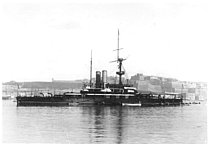

In [47]:
load_img(input_data_folder+"299281.jpg")

In [48]:
image_array = img_to_array(load_img(input_data_folder+"299281.jpg",target_size=(224, 224)))

# VGG16 expect a batch of images as input
img_batch = np.expand_dims(image_array, axis=0)
pred_results = model.predict(img_batch)

In [50]:
# Category Prediction
print(f"Category of ship: {np.argmax(pred_results,axis=1)[0]}")

Category of ship: 0


## Testing multiple images

In [51]:
labels_df = pd.read_csv(input_data_folder+'labels.csv')
labels_df.loc[:,"category"] = labels_df.loc[:,"category"].astype(str)
labels_df.head()

,image,category
0,2788353.jpg,0
1,2782131.jpg,0
2,2884349.jpg,0
3,2900596.jpg,0
4,2841543.jpg,0


In [52]:
# Stratified train-validation split split
image_train, image_val, category_train, category_val = train_test_split(labels_df.image, labels_df.category, test_size=0.2, stratify=labels_df.category, random_state=42)

In [53]:
val_df = labels_df.loc[labels_df.image.isin(image_val),:].copy()
val_df.groupby("category").count()

,image
category,
0,20
1,40
2,40
3,40
4,40


In [55]:
input_image_generators = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2, height_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    # rotation_range=30, fill_mode='nearest',
    # zoom_range=0.2
    )

In [56]:
validation_data_gen = input_image_generators.flow_from_dataframe(
		dataframe=val_df,
		directory=input_data_folder,
		x_col="image",
		y_col="category",
		batch_size=20,
		seed=42,
		shuffle=False,
		class_mode="categorical",
    target_size=(224,224))

Found 180 validated image filenames belonging to 5 classes.


In [60]:
nb_samples = validation_data_gen.n
prediction = model.predict(validation_data_gen,steps = nb_samples)

In [59]:
np.argmax(prediction, axis=1)

array([4, 0, 4, 0, 0, 0, 4, 4, 1, 0, 0, 0, 0, 4, 0, 0, 4, 0, 4, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 4, 1, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 4, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 3, 1, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4,
       1, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 0,
       4, 4, 1, 1])

In [61]:
val_df.loc[:,"prediction"] = np.argmax(prediction, axis=1)

In [62]:
print("Accuracy: ",round((val_df.category == val_df.prediction.astype(str)).sum() / 180 * 100,2) , "%")

Accuracy:  82.78 %
